In [8]:
ROOT_PATH = '../../../../'
# UKBB_DATA_PATH = ROOT_PATH + 'assets/data/ukbb/'
BASE_LOG_PATH = ROOT_PATH + 'medical_mesh_experiments/SVIExperiment'
# FIGURE_SAVE_PATH = 'figures'

In [9]:
import sys
import os

sys.path.append(ROOT_PATH)
# os.environ['CUDA_VISIBLE_DEVICES'] = ''
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

from tqdm import tqdm, trange

import traceback
import warnings
from scipy.stats import gaussian_kde

warnings.filterwarnings("ignore", category=UserWarning)

In [10]:
%matplotlib inline
import inspect
from collections import OrderedDict
from itertools import product
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyro
import torch
import seaborn as sns

torch.autograd.set_grad_enabled(False);

# import os
# os.system('/usr/bin/Xvfb :99 -screen 0 1024x768x24 &')
# os.environ['DISPLAY'] = ':99'

# import panel as pn
# pn.extension('vtk')

import pyvista as pv
pv.set_plot_theme("document")

# from coma.utils.visualise import plot_mesh_pyvista, plot_meshes_pyvista

In [11]:
# from coma.datasets.ukbb_meshdata import UKBBMeshDataset, VerticesDataLoader
# from coma.utils import transforms

# # Preprocessor
# preprocessor = transforms.get_transforms()

# brain_substructure = 'BrStem'

# # Load Dataset
# mesh_path = "/vol/biomedic3/bglocker/brainshapes"
# cache_path = "/vol/bitbucket/rrr2417/deepscm_data_cache"
# csv_path = "/vol/biomedic3/bglocker/brainshapes/ukb21079_extracted.csv"
# split = 0.8

# substructure_to_udi = {
#     'BrStem': '25025-2.0', 
#     'L_Thal': '25011-2.0',
#     'L_Caud': '25013-2.0',
#     'L_Puta': '25015-2.0',
#     'L_Pall': '25017-2.0',
#     'L_Hipp': '25019-2.0',
#     'L_Amyg': '25021-2.0',
#     'L_Accu': '25023-2.0',
#     'R_Thal': '25012-2.0',
#     'R_Caud': '25014-2.0',
#     'R_Puta': '25016-2.0',
#     'R_Pall': '25018-2.0',
#     'R_Hipp': '25020-2.0',
#     'R_Amyg': '25022-2.0',
#     'R_Accu': '25024-2.0',
# }

# feature_name_map = {
#     '31-0.0': 'sex',
#     '21003-0.0': 'age',
#     substructure_to_udi[brain_substructure]: 'structure_volume',  # Brain Stem
#     '25010-2.0': 'brain_volume',  # Unnormalised brain volume from UKBB
# }

# metadata_df = pd.read_csv(csv_path)

# total_train_dataset = UKBBMeshDataset(
#     mesh_path,
#     substructures=[brain_substructure],
#     split=split,
#     train=True,
#     transform=preprocessor,
#     reload_path=False,
#     features_df=metadata_df,
#     feature_name_map=feature_name_map,
#     cache_path=cache_path,
# )

# val_split = 0.1
# total_train_length = len(total_train_dataset)
# val_length = int(val_split * total_train_length)
# train_length = total_train_length - val_length

# train_dataset, val_dataset = torch.utils.data.random_split(
#     total_train_dataset,
#     lengths=[train_length, val_length],
#     generator=torch.Generator().manual_seed(42),
# )

# data = [train_dataset[i] for i in range(len(train_dataset))]
# meshes = torch.cat([mesh for (mesh, _) in data], 0).detach().numpy()
# print(meshes.shape)
# metadata_df = pd.concat([df for (_, df) in data], 0)
# print(metadata_df.shape)
# # metadata_df.head()
# torch.save(meshes, 'training_hipp_meshes.pt')
# metadata_df.to_csv('training_hipp_metadata.csv')

# print(preprocessor.transforms[-2].reg.fixed_image)

# metadata_df = pd.read_csv(csv_path)
# total_test_dataset = UKBBMeshDataset(
#     mesh_path,
#     substructures=[brain_substructure],
#     split=split,
#     train=False,
#     transform=preprocessor,
#     reload_path=True,
#     features_df=metadata_df,
#     feature_name_map=feature_name_map,
#     cache_path=cache_path,
# )
# data = [total_test_dataset[i] for i in range(len(total_test_dataset))]
# meshes = torch.cat([mesh for (mesh, _) in data], 0).detach().numpy()
# print(meshes.shape)
# print(preprocessor.transforms[-2].reg.fixed_image)
# metadata_df = pd.concat([df for (_, df) in data], 0)
# print(metadata_df.shape)
# metadata_df.head()
# torch.save(meshes, 'testing_hipp_meshes.pt')
# metadata_df.to_csv('testing_hipp_metadata.csv')

In [12]:
test_stem_meshes = torch.tensor(torch.load('testing_meshes.pt'))
test_stem_metadata_df = pd.read_csv('testing_metadata.csv')
print(test_stem_metadata_df.head())

train_stem_metadata_df = pd.read_csv('training_metadata.csv')
train_stem_meshes = torch.tensor(torch.load('training_meshes.pt'))
print(train_stem_metadata_df.head())

   Unnamed: 0      eid  sex  age  structure_volume  brain_volume
0        4804  5026976    0   58             23486       1073400
1        3178  5027256    1   60             25223       1282190
2        4669  5027577    0   65             24819       1097400
3         845  5027876    0   56             21884       1093200
4        4457  5028604    1   62             24066       1191110
   Unnamed: 0      eid  sex  age  structure_volume  brain_volume
0        8809  3820915    0   56             23764       1041180
1       11675  3677460    1   66             22000       1143400
2        9633  4383421    1   63             27148       1369520
3        8374  3069151    0   59             20223        980627
4       14213  1457636    0   50             21183       1386220


In [16]:
test_stem_meshes.shape

torch.Size([2901, 642, 3])

In [14]:
test_hipp_meshes = torch.tensor(torch.load('testing_hipp_meshes.pt'))
test_hipp_metadata_df = pd.read_csv('testing_hipp_metadata.csv')
print(test_hipp_metadata_df.head())

train_hipp_metadata_df = pd.read_csv('training_hipp_metadata.csv')
train_hipp_meshes = torch.tensor(torch.load('training_hipp_meshes.pt'))
print(train_hipp_metadata_df.head())

   Unnamed: 0      eid  sex  age  structure_volume  brain_volume
0        4804  5026976    0   58              3856       1073400
1        3178  5027256    1   60              4478       1282190
2        4669  5027577    0   65              3805       1097400
3         845  5027876    0   56              3900       1093200
4        4457  5028604    1   62              3911       1191110
   Unnamed: 0      eid  sex  age  structure_volume  brain_volume
0        8809  3820915    0   56             23764       1041180
1       11675  3677460    1   66             22000       1143400
2        9633  4383421    1   63             27148       1369520
3        8374  3069151    0   59             20223        980627
4       14213  1457636    0   50             21183       1386220


In [17]:
test_hipp_meshes.shape

torch.Size([2901, 664, 3])

In [6]:
template_path = '/vol/biomedic3/bglocker/brainshapes/5026976'
stem_name = 'T1_first-BrStem_first.vtk'
hipp_name = 'T1_first-R_Hipp_first.vtk'
stem_template = pv.read(f'{template_path}/{stem_name}')
hipp_template = pv.read(f'{template_path}/{hipp_name}')

In [ ]:
# _df = pd.read_csv(csv_path)
# base_dir_shapes = '/vol/biomedic3/bglocker/brainshapes/'
# min_x = float('-inf')
# for x in os.listdir(base_dir_shapes):
#     mesh = pv.read(f'{base_dir_shapes}/{x}/{stem_name}')
#     row = _df[_df.eid == int(x)][feature_name_map].rename(columns=feature_name_map)
#     batch = prep_batch(np.expand_dims(np.array(mesh.points), 0), row, 0, 1)
#     loss = brainstem_exps[99].svi.evaluate_loss(**batch)
#     metrics = brainstem_exps[99].get_trace_metrics(batch)
#     if metrics['log p(x)'] > min_x:
#         print(x, metrics['log p(x)'])
#         min_x = metrics['log p(x)']

## Load Model 

In [18]:
from deepscm.experiments.medical_meshes import ukbb  # noqa: F401
from deepscm.experiments.medical_meshes.base_experiment import EXPERIMENT_REGISTRY, MODEL_REGISTRY

In [19]:
import argparse

def load_model(base_log_path, exp='ConditionalVISEM', version='version_87', gpu=False):
    checkpoint_path = f'{base_log_path}/{exp}/{version}/'
    base_path = os.path.join(checkpoint_path, 'checkpoints')
    checkpoint_path = os.path.join(base_path, os.listdir(base_path)[0])
    
    # device = 'cuda' if gpu else 'cpu'
    ckpt = torch.load(checkpoint_path, map_location=torch.device('cpu'))
    hparams = ckpt['hyper_parameters']
    hparams['gpu'] = 1 if gpu else 0
    # print(hparams)

    model_class = MODEL_REGISTRY[hparams['model']]

    model_params = {
        k: v for k, v in hparams.items() if (
            k in inspect.signature(model_class.__init__).parameters
            or k in k in inspect.signature(model_class.__bases__[0].__init__).parameters
            or k in k in inspect.signature(model_class.__bases__[0].__bases__[0].__init__).parameters
        )
    }
    model_params['gpu'] = 1 if gpu else 0
    # print(model_params)

    new_state_dict = OrderedDict()

    for key, value in ckpt['state_dict'].items():
        new_key = key.replace('pyro_model.', '')
        new_state_dict[new_key] = value
    
    loaded_model = model_class(**model_params)
    loaded_model.load_state_dict(new_state_dict)

    for p in loaded_model._buffers.keys():
        if 'norm' in p:
            setattr(loaded_model, p, getattr(loaded_model, p))

    loaded_model.eval()

    def sample_pgm(num_samples, model):
        with pyro.plate('observations', num_samples):
            return model.pgm_model()

    model = partial(sample_pgm, model=loaded_model)
    
    hparams = argparse.Namespace(**hparams)
    exp_class = EXPERIMENT_REGISTRY['SVIExperiment']
    experiment = exp_class.load_from_checkpoint(
        checkpoint_path, pyro_model=loaded_model, hparams=hparams
    )
    
    return loaded_model, model, experiment

In [20]:
# _model = load_model(BASE_LOG_PATH, gpu=False)

In [21]:
exp = 'ConditionalVISEM'

brainstem_model_nos = [117]
brainstem_models_and_exp = [
    load_model(BASE_LOG_PATH, exp, f'version_{no}')
    for no in brainstem_model_nos
]

hipp_model_nos = [118] # , 120] # , 97, 101]
hipp_models_and_exp = [
    load_model(BASE_LOG_PATH, exp, f'version_{no}')
    for no in hipp_model_nos
]

def get_models_as_dict(model_nos, model_and_exp, idx):
    return {
        model_nos[i]: brainstem_models_and_exp[i][idx]
        for i in range(len(model_nos))
    }

brainstem_loaded_models = get_models_as_dict(brainstem_model_nos, brainstem_models_and_exp, 0)
brainstem_models = get_models_as_dict(brainstem_model_nos, brainstem_models_and_exp, 1)
brainstem_exps = get_models_as_dict(brainstem_model_nos, brainstem_models_and_exp, 2)

hipp_loaded_models = get_models_as_dict(hipp_model_nos, hipp_models_and_exp, 0)
hipp_models = get_models_as_dict(hipp_model_nos, hipp_models_and_exp, 1)
hipp_exps = get_models_as_dict(hipp_model_nos, hipp_models_and_exp, 2)

(642, 3)
++++++++++++++++ cpu
(664, 3)
++++++++++++++++ cpu


In [17]:
from tensorboard.backend.event_processing import event_accumulator

def load_scalars(path):
    """
    https://stackoverflow.com/questions/52756152/tensorboard-extract-scalar-by-a-script
    """
    event_acc = event_accumulator.EventAccumulator(path)
    event_acc.Reload()
    data = {}

    for tag in sorted(event_acc.Tags()["scalars"]):
        x, y = [], []

        for scalar_event in event_acc.Scalars(tag):
            x.append(scalar_event.step)
            y.append(scalar_event.value)

        data[tag] = (np.asarray(x), np.asarray(y))
    return data

In [19]:
path = f'{BASE_LOG_PATH}/{exp}/version_'

metrics = [
    'epoch', 'train/log p(age)', 'train/log p(brain_volume)', 'train/log p(sex)', 
    'train/log p(structure_volume)', 'train/log p(x)', 'train/loss',
    'val/log p(age)', 'val/log p(brain_volume)', 'val/log p(sex)',
    'val/log p(structure_volume)', 'val/log p(x)', 'val/loss'
]  
metrics_df = pd.DataFrame(columns=['model no'] + metrics)

for no in brainstem_model_nos:
    folder = path + str(no)
    scalars = load_scalars(f'{path}{no}')
    # print(scalars['reconstruction/mse'][1][-1])
    metrics_list = [no]
    for metric in metrics:
        metrics_list.append(scalars[metric][1][-1])
    _series = pd.Series(metrics_list, index=metrics_df.columns)
    # print(_series)
    metrics_df = metrics_df.append(_series, ignore_index=True)

In [20]:
metrics_df.head()

,model no,epoch,train/log p(age),train/log p(brain_volume),train/log p(sex),train/log p(structure_volume),train/log p(x),train/loss,val/log p(age),val/log p(brain_volume),val/log p(sex),val/log p(structure_volume),val/log p(x),val/loss
0,113.0,641.0,-3.330766,-12.841864,-0.692049,-8.972836,1584476.125,-405605312.0,-3.337967,-12.824196,-0.694385,-9.035886,106230.882812,-5590229.5
1,115.0,834.0,-3.237471,-12.721376,-0.689081,-9.018799,1636077.250,-418804032.0,-3.203741,-12.824153,-0.694385,-9.037717,117984.031250,-6166666.0
2,116.0,769.0,-3.374338,-12.833334,-0.693187,-9.092669,1642655.000,-420464640.0,-3.359365,-12.824040,-0.694385,-9.039929,54089.535156,-3022066.0
3,117.0,769.0,-3.351853,-12.783998,-0.687535,-8.971411,1578494.750,-404024800.0,-3.364362,-12.822951,-0.694385,-9.036569,99639.554688,-5273103.0


In [21]:
from pytorch3d.loss import chamfer_distance

In [22]:
# MSE + MAE
# 10993938
# 13429944.0
# 270227.03125

In [22]:
def prep_batch(meshes, df, lb, ub):
    mesh = torch.tensor(meshes[lb:ub]).float()
    age = torch.tensor(df.age.values[lb:ub]).unsqueeze(1).float()
    sex = torch.tensor(df.sex.values[lb:ub]).unsqueeze(1).float()
    structure_volume = torch.tensor(df.structure_volume.values[lb:ub]).unsqueeze(1).float()
    brain_volume = torch.tensor(df.brain_volume.values[lb:ub]).unsqueeze(1).float()
    batch = {
        'x': mesh,
        'age': age,
        'sex': sex,
        'structure_volume': structure_volume,
        'brain_volume': brain_volume,
    }
    return batch

def get_all_recon_metrics(model_nos, metadata_df, meshes, loaded_models, batch_size=100):
    # batch_size = 100
    recon_metrics = {
        no: {'mse': None, 'mae': None, 'chamfer': None}
        for no in model_nos
    }

    for no in model_nos:
        print(no)
        recons = []

        for i in range((meshes.shape[0] // batch_size) + 1):
            print(i)
            lb = i * batch_size
            ub = min(i * batch_size + batch_size, meshes.shape[0])

            batch = prep_batch(meshes, metadata_df, lb, ub)

            recon = loaded_models[no].reconstruct(**batch)
            recons.append(recon)

        recons = torch.cat(recons)
        recon_metrics[no]['mse'] = torch.nn.functional.mse_loss(recons, meshes)
        recon_metrics[no]['mae'] = torch.nn.functional.l1_loss(recons, meshes)
        recon_metrics[no]['chamfer'] = chamfer_distance(recons, meshes.float())[0]
    
    return recon_metrics

def get_all_likelihoods(model_nos, metadata_df, meshes, exps, batch_size=10):
    metric_names = [
        'log p(age)', 'log p(brain_volume)', 'log p(sex)', 
        'log p(structure_volume)', 'log p(x)',
    ]
    metrics_dict = {
        no: None
        for no in model_nos
    }

    for no in model_nos:
        print(no)
        
        _metrics_dict = {metric: [] for metric in metric_names}

        for i in range((meshes.shape[0] // batch_size) + 1):
            lb = i * batch_size
            ub = min(i * batch_size + batch_size, meshes.shape[0])
            
            batch = prep_batch(meshes, metadata_df, lb, ub)

            loss = exps[no].svi.evaluate_loss(**batch)
            metrics = exps[no].get_trace_metrics(batch)
            # print(metrics)
            # assembled = exps[no].assemble_epoch_end_outputs([{'loss': loss, **metrics}])
            # print(assembled)
            
            for metric in metric_names:
                _metrics_dict[metric].append(metrics[metric])
            
            # break

        metrics_dict[no] = {k: torch.mean(torch.stack(v)) for k, v in _metrics_dict.items()}
        # print(metrics_dict[no])
    
    return metrics_dict

In [33]:
test_stem_recon_metrics = get_all_recon_metrics(
    brainstem_model_nos,
    test_stem_metadata_df,
    test_stem_meshes,
    brainstem_loaded_models
)

113
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
115
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
116
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
117
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


In [34]:
test_stem_recon_metrics

{113: {'mse': tensor(136.7830, dtype=torch.float64),
  'mae': tensor(9.0300, dtype=torch.float64),
  'chamfer': tensor(282.6346)},
 115: {'mse': tensor(132.9508, dtype=torch.float64),
  'mae': tensor(8.8850, dtype=torch.float64),
  'chamfer': tensor(263.0884)},
 116: {'mse': tensor(131.5571, dtype=torch.float64),
  'mae': tensor(8.7223, dtype=torch.float64),
  'chamfer': tensor(249.5415)},
 117: {'mse': tensor(1.1315e+08, dtype=torch.float64),
  'mae': tensor(638.9036, dtype=torch.float64),
  'chamfer': tensor(3.3951e+08)}}

In [35]:
train_stem_recon_metrics = get_all_recon_metrics(
    brainstem_model_nos,
    train_stem_metadata_df,
    train_stem_meshes,
    brainstem_loaded_models
)

113
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
115
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
116
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
117
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
2

In [36]:
train_stem_recon_metrics

{113: {'mse': tensor(134.6524, dtype=torch.float64),
  'mae': tensor(7.7785, dtype=torch.float64),
  'chamfer': tensor(292.5182)},
 115: {'mse': tensor(130.4827, dtype=torch.float64),
  'mae': tensor(7.2003, dtype=torch.float64),
  'chamfer': tensor(263.6794)},
 116: {'mse': tensor(130.2792, dtype=torch.float64),
  'mae': tensor(7.4220, dtype=torch.float64),
  'chamfer': tensor(249.0836)},
 117: {'mse': tensor(1.7138e+25, dtype=torch.float64),
  'mae': tensor(6.9438e+09, dtype=torch.float64),
  'chamfer': tensor(5.1415e+25)}}

In [ ]:
test_stem_recon_likelihoods = get_all_likelihoods(
    brainstem_model_nos,
    test_stem_metadata_df,
    test_stem_meshes,
    brainstem_exps,
    batch_size=10,
)

In [26]:
test_stem_recon_likelihoods

{113: {'log p(age)': tensor(-3.3307),
  'log p(brain_volume)': tensor(-12.8191),
  'log p(sex)': tensor(-0.6916),
  'log p(structure_volume)': tensor(-9.0147),
  'log p(x)': tensor(-55770648.)},
 115: {'log p(age)': tensor(-3.2117),
  'log p(brain_volume)': tensor(-12.8198),
  'log p(sex)': tensor(-0.6916),
  'log p(structure_volume)': tensor(-9.0159),
  'log p(x)': tensor(-3.1362e+08)},
 116: {'log p(age)': tensor(-3.3583),
  'log p(brain_volume)': tensor(-12.8194),
  'log p(sex)': tensor(-0.6916),
  'log p(structure_volume)': tensor(-9.0132),
  'log p(x)': tensor(-3.0968e+08)},
 117: {'log p(age)': tensor(-3.3571),
  'log p(brain_volume)': tensor(-12.8194),
  'log p(sex)': tensor(-0.6916),
  'log p(structure_volume)': tensor(-9.0141),
  'log p(x)': tensor(-5083699.)}}

In [ ]:
train_stem_recon_likelihoods = get_all_likelihoods(
    brainstem_model_nos,
    train_stem_metadata_df,
    train_stem_meshes,
    brainstem_exps,
    batch_size=100,
)

113
115
116


In [30]:
train_stem_recon_likelihoods

{113: {'log p(age)': tensor(-3.3299),
  'log p(brain_volume)': tensor(-12.8100),
  'log p(sex)': tensor(-0.6921),
  'log p(structure_volume)': tensor(-9.0159),
  'log p(x)': tensor(-48897808.)},
 115: {'log p(age)': tensor(-3.2111),
  'log p(brain_volume)': tensor(-12.8092),
  'log p(sex)': tensor(-0.6921),
  'log p(structure_volume)': tensor(-9.0149),
  'log p(x)': tensor(-3.2001e+08)},
 116: {'log p(age)': tensor(-3.3601),
  'log p(brain_volume)': tensor(-12.8097),
  'log p(sex)': tensor(-0.6921),
  'log p(structure_volume)': tensor(-9.0145),
  'log p(x)': tensor(-3.0809e+08)},
 117: {'log p(age)': tensor(-3.3571),
  'log p(brain_volume)': tensor(-12.8093),
  'log p(sex)': tensor(-0.6921),
  'log p(structure_volume)': tensor(-9.0147),
  'log p(x)': tensor(-2872212.7500)}}

In [ ]:
# test_hipp_recon_likelihoods = get_all_likelihoods(
#     hipp_model_nos,
#     test_hipp_metadata_df,
#     test_hipp_meshes,
#     hipp_loaded_models,
# )

In [ ]:
# test_hipp_recon_likelihoods

In [ ]:
train_hipp_recon_metrics = get_all_metrics(
    hipp_model_nos,
    train_hipp_metadata_df,
    train_hipp_meshes,
    hipp_loaded_models,
)

In [ ]:
train_hipp_recon_metrics

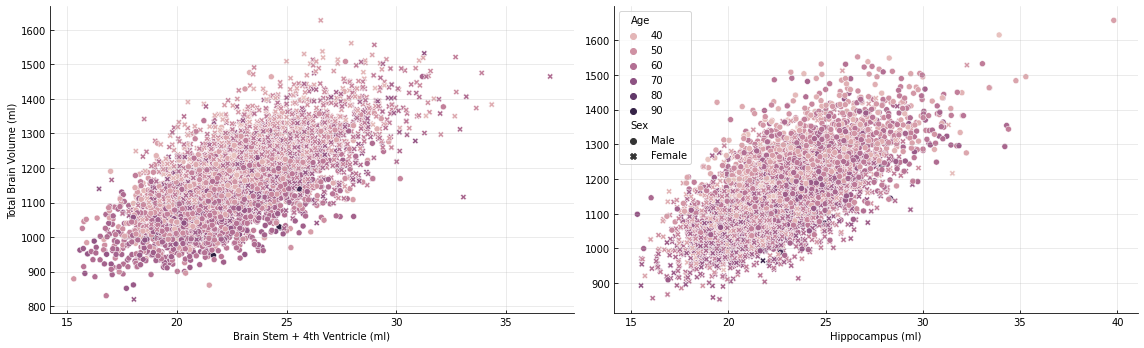

In [26]:
width = 16
height = width / (1.618 * 2)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(width, height))

n_samples = 5000

_brainstem_samples = brainstem_models[brainstem_model_nos[0]](n_samples)
_hipp_samples = hipp_models[hipp_model_nos[0]](n_samples)

brainstem_samples = np.stack([var.int().numpy().flatten() for var in _brainstem_samples])
columns = [
    'Age',
    'Sex',
    'Brain Stem + 4th Ventricle (ml)',
    'Total Brain Volume (ml)'
]
df = pd.DataFrame(brainstem_samples.T, columns=columns)
df[columns[2]] /= 1000
df[columns[3]] /= 1000
df.replace({'Sex': {0: 'Female', 1: 'Male'}}, inplace=True)
ax = sns.scatterplot(data=df, x=columns[2], y=columns[3], hue=columns[0], style=columns[1], ax=axes[0])
ax.get_legend().remove()
ax.tick_params(axis='y', direction='in')
ax.tick_params(axis='x', direction='in')
ax.set_xlabel(ax.get_xlabel(), fontsize='medium')
ax.set_ylabel(ax.get_ylabel(), fontsize='medium')
ax.grid('on', lw=.5, alpha=.5)

columns = [
    'Age',
    'Sex',
    'Hippocampus (ml)',
    'Total Brain Volume (ml)',
]
hipp_samples = np.stack([var.int().numpy().flatten() for var in _hipp_samples])
df = pd.DataFrame(hipp_samples.T, columns=columns)
df[columns[2]] /= 1000
df[columns[3]] /= 1000
df.replace({'Sex': {0: 'Female', 1: 'Male'}}, inplace=True)
ax = sns.scatterplot(data=df, x=columns[2], y=columns[3], hue=columns[0], style=columns[1], ax=axes[1])
ax.set(ylabel=None)
ax.tick_params(axis='y', direction='in')
ax.tick_params(axis='x', direction='in')
ax.set_xlabel(ax.get_xlabel(), fontsize='medium')
ax.grid('on', lw=.5, alpha=.5)

sns.despine()
plt.tight_layout()
plt.savefig('total_to_subcortial_pairplot_results.png', dpi=300)
plt.show()

## Conditional Samples

In [58]:
model = loaded_models[exp]

b_range = [800000., 1200000., 1600000.]
v_range = [10000., 28000., 40000.]

samples = {
    'x': [],
    'brain_volume': [],
    'structure_volume': [],

}

save_name = f'{exp}_cond_samples'

# for _ in range(num_ex):
z = model.sample(1)[1]

for i, brain_volume in enumerate(b_range):
    for j, structure_volume in enumerate(v_range):
        brain_volume = torch.tensor([[brain_volume]])
        structure_volume = torch.tensor([[structure_volume]])
        data = {
            'z': z,
            'brain_volume': brain_volume,
            'structure_volume': structure_volume,
        }
        
        x, *_ = pyro.condition(loaded_models[exp].sample, data=data)(1)
        template_copy = template.copy()
        template_copy.points = x[0].numpy()
        samples['x'] += [template_copy]
        samples['brain_volume'] += [brain_volume]
        samples['structure_volume'] += [structure_volume]

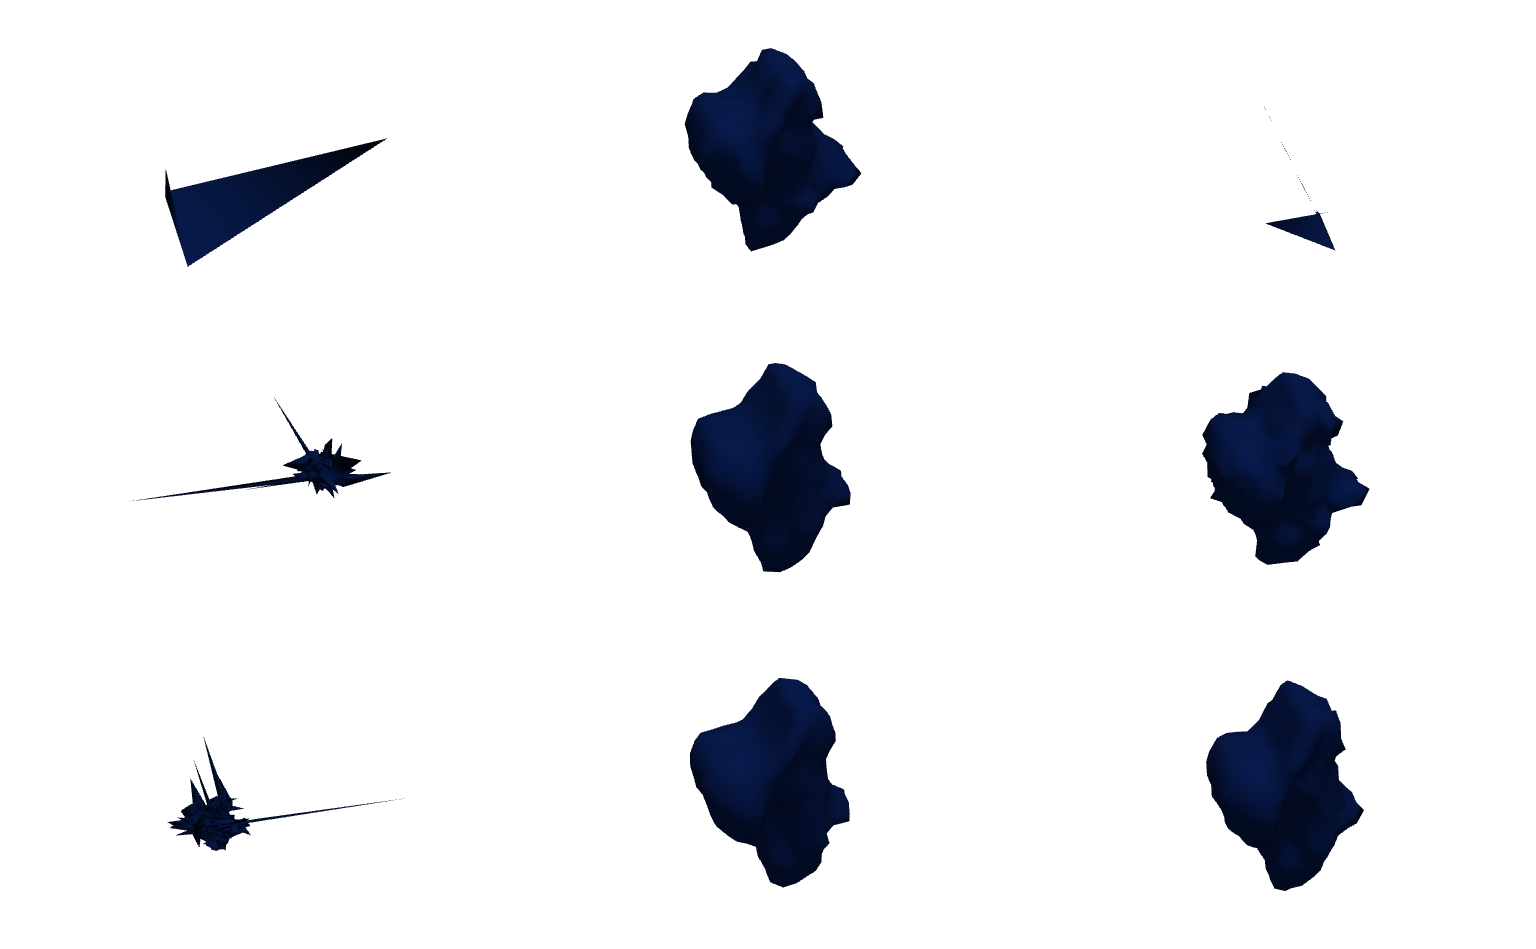

[(124.1944237236261, -20.320286702704465, 147.16279702227112),
 (31.99851703643799, -112.51619338989258, 54.96689033508301),
 (0.0, 0.0, 1.0)]

In [60]:
width = 768 * 2
height = int(width / (1.618))

rotations = [(0, 0, 240)]

plotter = pv.Plotter(
    shape=(len(b_range), len(v_range)),
    window_size=(width, height),
    border=False,
    lighting='light_kit',
    off_screen=True,
    notebook=True,
)

plot_meshes_pyvista(
    plotter,
    samples['x'],  # polydatas,
    rotations=rotations * len(b_range) * len(v_range),
    vertexcolors=np.ones((9, 642, 3)) * 100,
    vertexscalar='distance',
    scalar_bar_idx=None, # len(b_range) * len(v_range) - 1,
    titles=[''] * len(b_range) * len(v_range), # [f'Mode {x - 1}' for x in modes] + [''] * n_modes * (n_laps - 1),
    mesh_kwargs=dict(
        smooth_shading=True
    ),
    scalar_bar_kwargs=dict(
        label_font_size=10,
        position_x=0.85,
        title_font_size=10,
        shadow=True,
        n_labels=2,
        fmt='%.2f',
    ),
)

plotter.show(screenshot='conditional_brain_stem_samples.png')

## Reconstructions